# Guided Project :
# Predicting the stock market

## The dataset

Welcome to a Dataquest guided project! If you haven't gone through a guided project yet, we recommend starting with the first one in the command line course.<br>

In this project, you'll be working with data from the S&P500 Index. The S&P500 is a stock market index. Before we get into what an index is, we'll need to get into the basics of the stock market.<br>

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When you buy or sell shares, it's common to say that you're trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015 -- http://www.nasdaq.com/symbol/aapl. A stock that is in less demand, like Ford Motor Company, has a lower price -- http://finance.yahoo.com/q?s=F. Stock price is also influenced by other factors, including the number of shares a company has issued.<br>

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.<br>

Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of `30` large American companies together. The S&P500 Index aggregates the stock prices of `500` large companies. When an index fund goes up or down, you can say that the underlying market or sector it represents is also going up or down. For example, if the Dow Jones Industrial Average price goes down one day, you can say that American stocks overall went down (ie, most American stocks went down in price).<br>

You'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.<br>

There are also thousands of traders who make money by buying and selling [Exchange Traded Funds](https://en.wikipedia.org/wiki/Exchange-traded_fund). ETFs allow you to buy and sell indexes like stocks. This means that you could "buy" the S&P500 Index ETF when the price is low, and sell when it's high to make a profit. Creating a predictive model could allow traders to make money on the stock market.<br>

**Note: You shouldn't make trades with any models developed in this mission. Trading stocks has risks, and nothing in this mission constitutes stock trading advice.**<br>

In this mission, you'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from `1950` to `2015`. The dataset is stored in `sphist.csv`.

The columns of the dataset are:

* `Date` -- The date of the record.
* `Open` -- The opening price of the day (when trading starts).
* `High` -- The highest trade price during the day.
* `Low` -- The lowest trade price during the day.
* `Close` -- The closing price for the day (when trading is finished).
* `Volume` -- The number of shares traded.
* `Adj Close` -- The daily closing price, adjusted retroactively to include any corporate actions. Read more [here](http://www.investopedia.com/terms/a/adjusted_closing_price.asp).

You'll be using this dataset to develop a predictive model. You'll train the model with data from `1950-2012`, and try to make predictions from `2013-2015`.

## Reading in the data

* Read the data into a Pandas DataFrame. You can use the `read_csv` Pandas function for this.
* Convert the `Date` column to a Pandas date type. This will allow you to do date comparisons with the column.
  * You can perform this conversion with the [to_datetime](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) function in Pandas.
  * Once you convert the column, you can perform comparisons with `df["Date"] > datetime(year=2015, month=4, day=1)`. This will generate a Boolean series that tells you if each item in the `Date` column is after `2015-04-01`. You'll have to import the datetime module from the [datetime library](https://docs.python.org/3/library/datetime.html) first with `from datetime import datetime`.
* Sort the dataframe on the `Date` column. It's currently in descending order, but we'll want it to be in ascending order for some of the next steps. You can use the [DataFrame.sort_values()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html) method on data frames for this.


In [18]:
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
sphist = pd.read_csv('sphist.csv')
sphist.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [4]:
# convert 'Date' column into datetime type
sphist['Date'] = pd.to_datetime(sphist['Date'])

In [5]:
# sort by 'Date' in ascending order
sphist = sphist.sort_values(by='Date', ascending=True)

## Generating indicators

### Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes time to make predictions. 
In a normal machine learning exercise, we treat each row as **independent**. Stock market data is **sequential**, and each observation comes a day after the previous observation. Thus, the observations are **not all independent**, and you can't treat them as such.<br>

This means you have to be extra careful to **not inject "future" knowledge into past rows** when you do training and prediction. 
* Injecting future knowledge will make our model look good when you're training and testing it, but will make it fail in the real world. 
* This is how many algorithmic traders lose money.

The time series nature of the data means that can generate indicators to make our model more accurate. For instance, you can create **a new column that contains the average price of the last 10 trades for each row**. 
* This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.
* When you do this, you have to be careful not to use the current row in the values you average. You want to teach the model how to predict the current price from historical prices.
* If you include the current price in the prices you average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where you don't know the price upfront.

Here are some indicators that are interesting to generate for each row:

* The average price from the past `5` days.
* The average price for the past `30` days.
* The average price for the past `365` days.
* The ratio between the average price for the past `5` days, and the average price for the past `365` days.
* The standard deviation of the price over the past `5` days.
* The standard deviation of the price over the past `365` days.
* The ratio between the standard deviation for the past `5` days, and the standard deviation for the past `365` days.

"Days" means "trading days" -- so if you're computing the average of the past `5` days, it should be the `5` most recent dates before the current one. Assume that "price" means the `Close` column. 
* **Always be careful not to include the current price in these indicators!** 
* You're predicting the next day price, so our indicators are designed to predict the current price from the previous prices.

Some of these indicators require a year of historical data to compute. Our first day of data falls on `1950-01-03`, so the first day you can start computing indicators on is `1951-01-03`.<br>

To compute indicators, you'll need to loop through each day from `1951-01-03` to `2015-12-07` (the last day you have prices for). For instance, if we were computing the average price from the past `5` days, we'd start at `1951-01-03`, get the prices for each day from `1950-12-26` to `1951-01-02`, and find the average. 
* The reason **why we start on the 26th**, and take more than 5 calendar days into account is **because the stock market is shutdown on certain holidays**.
* Since we're looking at the past 5 trading days, we need to look at more than 5 calendar days to find them. Here's a diagram showing how we average 5 days to get the average closing price for `1951-01-03`:

![](img/1_cp.png)

You'd then move to `1951-01-04`, and find the average price from `1950-12-30` to `1951-01-03`. Here's a diagram showing how we might compute the average here:

![](img/2.png)


We'd keep repeating this process to compute all of the averages. Note how when we compute the average of the past `5` days for `1951-01-04`, we don't include `1951-01-04` in that average. It's critical not to do this, or our model won't work in the "real world".<br>

Here's a table of how the first `10` dates would look if we computed the `5` day average closing price. `Close` is the closing price for that day, and `day_5` is the average of the past `5` trading closing prices at each row:

![](img/3.png)

Pick `3` indicators to compute, and generate a different column for each one. There are a few different ways to do this:

1. You can use a for loop along with the [iterrows](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.iterrows.html) method to loop over the rows in the DataFrame and compute the indicators. This is the recommended way, as it's a bit simpler to understand what's happening. Since you'll be looping over all of the rows, for any date that comes before there is enough historical data to compute an indicator, just fill in `0`.
2. Pandas has some [time series tools](http://pandas.pydata.org/pandas-docs/stable/computation.html) that can help, including the [rolling_mean](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html) function, which will do most of the hard computation for you. Set the `window` equal to the number of trading days in the past you want to use to compute the indicators. This will add in `NaN` values for any row where there aren't enough historical trading days to do the computation. 
  * Note: There is a giant caveat here, which is that the rolling mean will use the current day's price. You'll need to reindex the resulting series to shift all the values "forward" one day. 
  * For example, the rolling mean calculated for `1950-01-03` will need to be assigned to `1950-01-04`, and so on. You can use the [shift](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.shift.html) method on Dataframes to do this.

In [37]:
# using way 1.

def create_indicator_past(df, current_rownum, how, day):
    '''
    how = ['avg', 'std']
    '''
    
    if current_rownum < day:
        return 0
    
    start = current_rownum - day
    end = current_rownum
    tot = df.iloc[start:end]['Close']
    
    if how == 'avg': return tot.mean()
    else: return tot.std()


In [40]:
avg_close_past5, avg_close_past30, avg_close_past365 = [], [], []
std_close_past5, std_close_past30, std_close_past365 = [], [], []
ratio_avg_close_past_5_365, ratio_std_close_past_5_365 = [], []

In [41]:
for i in range(sphist.shape[0]):
    
    # calculate and store some values used for multiple times
    avg_past5 = create_indicator_past(sphist, i, 'avg', 5)
    avg_past365 = create_indicator_past(sphist, i, 'avg', 365)
    std_past5 = create_indicator_past(sphist, i, 'std', 5)
    std_past365 = create_indicator_past(sphist, i, 'std', 365)
    
    # average closing price (~ 5 days)
    avg_close_past5.append(avg_past5)
    avg_close_past30.append(create_indicator_past(sphist, i, 'avg', 30))
    avg_close_past365.append(avg_past365)
    
    # standard deviation of closing price ( ~ 5 days)
    std_close_past5.append(std_past5)
    std_close_past30.append(create_indicator_past(sphist, i, 'std', 30))
    std_close_past365.append(std_past365)
    
    # ratio values
    if (avg_past5 != 0) and (avg_past365 != 0):
        ratio_avg_close_past_5_365.append(avg_past5/avg_past365)
    else:
        ratio_avg_close_past_5_365.append(0)
    
    if (std_past5 != 0) and (std_past365 != 0):
        ratio_std_close_past_5_365.append(std_past5/std_past365)
    else:
        ratio_std_close_past_5_365.append(0)

In [42]:
sphist['avg_close_past5'] = avg_close_past5
sphist['avg_close_past30'] = avg_close_past30
sphist['avg_close_past365'] = avg_close_past365

sphist['std_close_past5'] = std_close_past5
sphist['std_close_past30'] = std_close_past30
sphist['std_close_past365'] = std_close_past365

sphist['ratio_avg_close_past_5_365'] = ratio_avg_close_past_5_365
sphist['ratio_std_close_past_5_365'] = ratio_std_close_past_5_365

## Splitting up the data

* Remove any rows from the DataFrame that fall before `1951-01-03`.
* Use the dropna method to remove any rows with `NaN` values. Pass in the `axis=0` argument to drop rows.
* Generate two new dataframes to use in making our algorithm. `train` should contain any rows in the data with a date less than `2013-01-01`. test should contain any rows with a date greater than or equal to `2013-01-01`.

In [45]:
after_1951_01_03 = sphist['Date'] >= datetime(year=1951, month=1, day=3)
sphist_ = sphist[after_1951_01_03].dropna(how='any', axis=0)

In [47]:
train_index = sphist_['Date'] < datetime(year=2013, month=1, day=1)
test_index = sphist_['Date'] >= datetime(year=2013, month=1, day=1)

train = sphist_[train_index]
test = sphist_[test_index]

In [50]:
train.shape

(15601, 15)

In [51]:
test.shape

(739, 15)

## Making predictions

Now, you can define an error metric, train a model using the `train` data, and make predictions on the `test` data.<br>

It's recommended to use [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), also called MAE, as an error metric, because it will show you how "close" you were to the price in intuitive terms. [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error), or MSE, is an alternative that is more commonly used, but makes it harder to intuitively tell how far off you are from the true price because it squares the error.

* Pick an error metric.
* Initialize an instance of the LinearRegression class.
* Train a linear regression model, using the train Dataframe. Leave out all of the original columns (Close, High, Low, Open, Volume, Adj Close, Date) when training your model. These all contain knowledge of the future that you don't want to feed the model. Use the Close column as the target.
* Make predictions for the Close column of the test data, using the same columns for training as you did with train.
* Compute the error between the predictions and the Close column of test.

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [57]:
lr = LinearRegression()

original_cols = ['Close', 'High', 'Low', 'Open', 'Volume',
                'Adj Close', 'Date']
X_train = train.drop(original_cols, axis=1)
y_train = train['Close']
X_test = test.drop(original_cols, axis=1)
y_test = test['Close']

lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mae = mean_absolute_error(pred, y_test)

print(mae)

16.2177313022


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

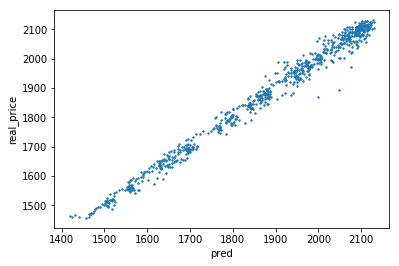

In [69]:
plt.scatter(pred, y_test, s=2); plt.xlabel('pred'); plt.ylabel('real_price'); plt.show()

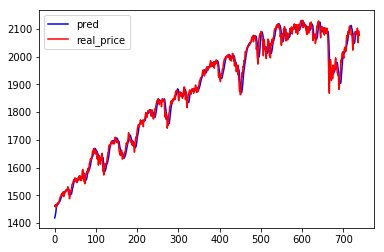

In [68]:
plt.plot(range(len(pred)), pred, c='b', label='pred')
plt.plot(range(len(y_test)), y_test, c='r', label='real_price')
plt.legend()
plt.show()

## Improving error

Congratulations! You can now predict the S&P500 (with some error). You can improve the error of this model significantly, though. Think about some indicators that might be helpful to compute.

#### Here are some ideas that might be helpful:

* The average volume over the past five days.
* The average volume over the past year.
* The ratio between the average volume for the past five days, and the average volume for the past year.
* The standard deviation of the average volume over the past five days.
* The standard deviation of the average volume over the past year.
* The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
* The year component of the date.
* The ratio between the lowest price in the past year and the current price.
* The ratio between the highest price in the past year and the current price.
* The year component of the date.
* The month component of the date.
* The day of week.
* The day component of the date.
* The number of holidays in the prior month.

In [70]:
sphist.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'avg_close_past5', 'avg_close_past30', 'avg_close_past365',
       'std_close_past5', 'std_close_past30', 'std_close_past365',
       'ratio_avg_close_past_5_365', 'ratio_std_close_past_5_365'],
      dtype='object')

In [71]:
def create_indicator2_past(df, current_rownum, how, day):
    '''
    how = ['avg', 'std']
    '''
    
    if current_rownum < day:
        return 0
    
    start = current_rownum - day
    end = current_rownum
    tot = df.iloc[start:end]['Volume']
    
    if how == 'avg': return tot.mean()
    else: return tot.std()

In [72]:
avg_vol_past5, avg_vol_past30, avg_vol_past365 = [], [], []
std_vol_past5, std_vol_past30, std_vol_past365 = [], [], []
ratio_avg_vol_past_5_365, ratio_std_vol_past_5_365 = [], []

In [73]:
for i in range(sphist.shape[0]):
    
    # calculate and store some values used for multiple times
    avg_past5 = create_indicator2_past(sphist, i, 'avg', 5)
    avg_past365 = create_indicator2_past(sphist, i, 'avg', 365)
    std_past5 = create_indicator2_past(sphist, i, 'std', 5)
    std_past365 = create_indicator2_past(sphist, i, 'std', 365)
    
    # average closing volumne (~ 5 days)
    avg_vol_past5.append(avg_past5)
    avg_vol_past30.append(create_indicator2_past(sphist, i, 'avg', 30))
    avg_vol_past365.append(avg_past365)
    
    # standard deviation of volume ( ~ 5 days)
    std_vol_past5.append(std_past5)
    std_vol_past30.append(create_indicator2_past(sphist, i, 'std', 30))
    std_vol_past365.append(std_past365)
    
    # ratio values
    if (avg_past5 != 0) and (avg_past365 != 0):
        ratio_avg_vol_past_5_365.append(avg_past5/avg_past365)
    else:
        ratio_avg_vol_past_5_365.append(0)
    
    if (std_past5 != 0) and (std_past365 != 0):
        ratio_std_vol_past_5_365.append(std_past5/std_past365)
    else:
        ratio_std_vol_past_5_365.append(0)

In [74]:
sphist['avg_vol_past5'] = avg_vol_past5
sphist['avg_vol_past30'] = avg_vol_past30
sphist['avg_vol_past365'] = avg_vol_past365

sphist['std_vol_past5'] = std_vol_past5
sphist['std_vol_past30'] = std_vol_past30
sphist['std_vol_past365'] = std_vol_past365

sphist['ratio_avg_vol_past_5_365'] = ratio_avg_vol_past_5_365
sphist['ratio_std_vol_past_5_365'] = ratio_std_vol_past_5_365

In [78]:
sphist['year'] = sphist['Date'].apply(lambda x: x.year)
sphist['month'] = sphist['Date'].apply(lambda x: x.month)
sphist['day'] = sphist['Date'].apply(lambda x: x.day)

In [79]:
after_1951_01_03 = sphist['Date'] >= datetime(year=1951, month=1, day=3)
sphist_ = sphist[after_1951_01_03].dropna(how='any', axis=0)

In [80]:
train_index = sphist_['Date'] < datetime(year=2013, month=1, day=1)
test_index = sphist_['Date'] >= datetime(year=2013, month=1, day=1)

train = sphist_[train_index]
test = sphist_[test_index]

## After adding 11 features:
#### Mean Absolute Error
* 16.218 -> 16.178

In [81]:
lr = LinearRegression()

original_cols = ['Close', 'High', 'Low', 'Open', 'Volume',
                'Adj Close', 'Date']
X_train = train.drop(original_cols, axis=1)
y_train = train['Close']
X_test = test.drop(original_cols, axis=1)
y_test = test['Close']

lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mae = mean_absolute_error(pred, y_test)

print(mae)

16.1774887177


## Feature Selection using RFE (recursive feature elimination)

In [82]:
import seaborn as sns

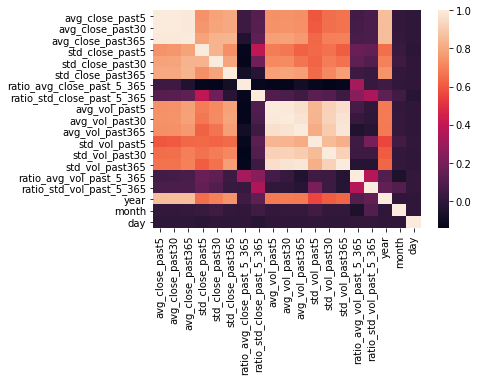

In [85]:
sns.heatmap(X_train.corr())

In [86]:
from sklearn.feature_selection import RFE

In [87]:
selector = RFE(LinearRegression(), 10)
selector.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [90]:
selector.support_

array([ True,  True, False,  True,  True, False,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True, False], dtype=bool)

In [92]:
rfe_top10 = X_train.columns[selector.support_]
rfe_top10

Index(['avg_close_past5', 'avg_close_past30', 'std_close_past5',
       'std_close_past30', 'ratio_avg_close_past_5_365',
       'ratio_std_close_past_5_365', 'ratio_avg_vol_past_5_365',
       'ratio_std_vol_past_5_365', 'year', 'month'],
      dtype='object')

## Cross validation using KFold

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [98]:
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=0)
k5_cross_scores = cross_val_score(estimator=model,
                                   X = sphist_.drop(original_cols,axis=1),
                                   y = sphist_['Close'],
                                   cv = kf, scoring='r2')

In [99]:
k5_cross_scores.mean()

0.99959304983255493

In [101]:
k5_cross_scores_rfe10 = cross_val_score(estimator=model,
                                   X = sphist_.drop(original_cols,axis=1)[rfe_top10],
                                   y = sphist_['Close'],
                                   cv = kf, scoring='r2')
k5_cross_scores_rfe10.mean()

0.99959319266524693